***Цель проекта:*** Рассмотреть зависимость ВВП и уровня инфляции от степени занятости населения на примере 5 восточноевропейских стран: Польши, Чехии, Венгрии, Румынии и Болгарии.

Эти страны относительно недавно перешли в условия рыночной экономики, а также их экономические показатели более независимы от общеевропеских тенденций, так как они используют свою национальную валюту вместо евро.

***Наша основная гипотеза:*** Математические ожидания для следующих пар равны: ВВП и уровень безработы, Инфляция и уровень безработицы

In [99]:
import requests #Библиотека, позволяющая подключаться к сайтам
import pandas as pd
from bs4 import BeautifulSoup #Библиотека для парсинга сайта
from io import BytesIO #библиотека для чтения данных
import matplotlib.pyplot as plt
from matplotlib import ticker #Модуль для форматирования визуализации
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression

# ***ВАЛОВЫЙ ВНУТРЕННИЙ ПРОДУКТ***





In [100]:
#Подключаемся к сайту Мирового Банка, чтобы выгрузить excel таблицу с данными
GDP = 'https://data.worldbank.org/indicator/NY.GDP.MKTP.CD'
page = requests.get(GDP)
soup = BeautifulSoup(page.text, "html.parser")
GDP_file = soup.find_all('div', class_='btn-item download')
GDP = GDP_file[0].find_all('a')
GDP = GDP[-1].get('href')
url = f'{GDP}'
response = requests.get(url)
#Создаем датафрейм на основе выгруженной таблицы, форматируем датафрем
#так как в изначальной таблице первые 3 строчки - пустые либо заполнены информацией об организации
#названия столбцов находятся на 3 строке, а данные начинаются с 4
df = pd.read_excel(BytesIO(response.content))
df.columns = df.iloc[2]
df = df.drop([0, 1, 2])
#Изменяем вид отображения названий столбцов, чтобы год имел тип данных int
#Иначе в таблце название будет представлено, например, как 1960.0
skip_cols = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
for col in df.columns:
    if col not in skip_cols:
        df.rename(columns={col: int(float(col))}, inplace=True)
pd.options.display.float_format ='{:,.0f}'.format
df.columns.name = None
#Обнуляем индексы из-за предыдущих махинаций, выводим датафрейм
df.index = range(0, len(df), 1)
GDP_df = df
GDP_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,"2,790,849,721","2,962,907,263","2,983,635,196","3,092,429,050","3,276,184,358","3,395,798,883","2,558,906,304","3,103,184,102","3,544,707,788",NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,"979,690,460,651","899,255,563,489","829,738,293,632","939,959,327,939","1,012,521,425,296","1,006,191,000,190","928,880,235,177","1,086,530,704,901","1,185,137,703,651",NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,"537,777,811","548,888,896","546,666,678","751,111,191","800,000,044","1,006,666,638",...,"20,497,128,600","19,134,221,745","18,116,572,399","18,753,456,507","18,053,222,735","18,799,444,415","19,955,929,061","14,266,499,430",NaN,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,"10,411,646,287","11,135,924,728","11,951,712,282","12,685,805,890","13,848,998,669","14,874,755,834",...,"894,505,003,403","769,263,195,357","692,114,931,613","685,630,289,667","768,158,194,632","823,405,580,188","786,962,436,538","844,927,536,438","875,393,693,658",NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,"135,966,802,157","90,496,420,626","52,761,617,226","73,690,155,047","79,450,688,232","70,897,962,713","48,501,561,230","66,505,129,989","106,782,770,715",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,"7,074,394,735","6,295,848,423","6,682,677,290","7,180,764,703","7,878,759,715","7,899,737,577","7,717,145,218","9,412,034,299","9,409,473,518",NaN
262,"Yemen, Rep.",YEM,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,"43,228,585,321","42,444,489,522","31,317,824,943","26,842,228,829","21,606,160,784",NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,GDP (current US$),NY.GDP.MKTP.CD,"8,748,596,501","9,225,996,310","9,813,996,074","10,854,195,658","11,955,995,218","13,068,994,772",...,"381,198,869,776","346,709,790,459","323,585,509,674","381,448,814,655","405,260,723,893","389,330,032,221","338,291,396,026","420,117,812,464","405,270,850,099",NaN
264,Zambia,ZMB,GDP (current US$),NY.GDP.MKTP.CD,"713,000,000","696,285,714","693,142,857","718,714,286","839,428,571","1,082,857,143",...,"27,141,023,558","21,251,216,799","20,958,412,538","25,873,601,261","26,311,507,274","23,308,667,781","18,110,638,269","22,096,416,934","29,163,782,138",NaN


In [101]:
#Создаем списки значений, которые нам нужны, а именно выбранные страны и отрезок времени
countries = [GDP_df[GDP_df['Country Name'] == 'Bulgaria'].index[0], GDP_df[GDP_df['Country Name'] == 'Poland'].index[0], GDP_df[GDP_df['Country Name'] == 'Czechia'].index[0], GDP_df[GDP_df['Country Name'] == 'Hungary'].index[0], GDP_df[GDP_df['Country Name'] == 'Romania'].index[0]]
columns = ['Country Name']
for i in range(1999,2023):
  columns.append(i)

In [102]:
#Создаем новый датафрейм, в котором содержатся только нужные нам данные
#Добавляем новые столбцы - процентное изменение ВВП
sorted_df = GDP_df.loc[countries, columns]
sorted_df.index = range(0, len(sorted_df), 1)
x = sorted_df.T
x.columns = x.iloc[0]
x['Year'] = x.index
x.index = range(0,len(x), 1)
x = x[['Year', 'Bulgaria', 'Poland', 'Czechia', 'Hungary', 'Romania']]
x = x.drop([0])
x.index = range(0,len(x), 1)
x.columns.name = None
x['Bul_Percent'] = x['Bulgaria'].pct_change()*100
x['Pol_Percent'] = x['Poland'].pct_change()*100
x['Cze_Percent'] = x['Czechia'].pct_change()*100
x['Hun_Percent'] = x['Hungary'].pct_change()*100
x['Rom_Percent'] = x['Romania'].pct_change()*100
x

,Year,Bulgaria,Poland,Czechia,Hungary,Romania,Bul_Percent,Pol_Percent,Cze_Percent,Hun_Percent,Rom_Percent
0,1999,"13,627,325,461","170,030,662,135","65,173,130,995","49,073,380,174","35,953,156,754",NaN,NaN,NaN,NaN,NaN
1,2000,"13,245,990,274","172,220,451,787","61,828,166,496","47,218,405,892","37,253,739,511",-3,1,-5,-4,4
2,2001,"14,183,446,026","190,905,493,539","67,808,032,980","53,749,989,092","40,395,116,581",7,11,10,14,8
3,2002,"16,403,043,850","199,070,448,695","82,196,001,051","67,608,919,144","46,065,502,703",16,4,21,26,14
4,2003,"21,144,957,990","217,828,661,057","100,090,467,581","85,285,062,818","57,806,384,143",29,9,22,26,25
5,2004,"26,157,743,369","255,107,252,159","119,814,434,354","104,120,820,259","74,973,656,852",24,17,20,22,30
6,2005,"29,868,657,858","306,145,944,825","137,143,471,328","113,211,158,293","98,454,380,120",14,20,14,9,31
7,2006,"34,380,536,496","344,626,667,414","156,264,095,665","115,715,618,613","122,023,735,993",15,13,14,2,24
8,2007,"44,432,811,756","429,020,755,433","190,183,800,884","140,186,716,681","174,588,782,939",29,24,22,21,43
9,2008,"54,480,684,188","533,599,779,516","236,816,485,763","158,325,614,581","214,317,202,478",23,24,25,13,23


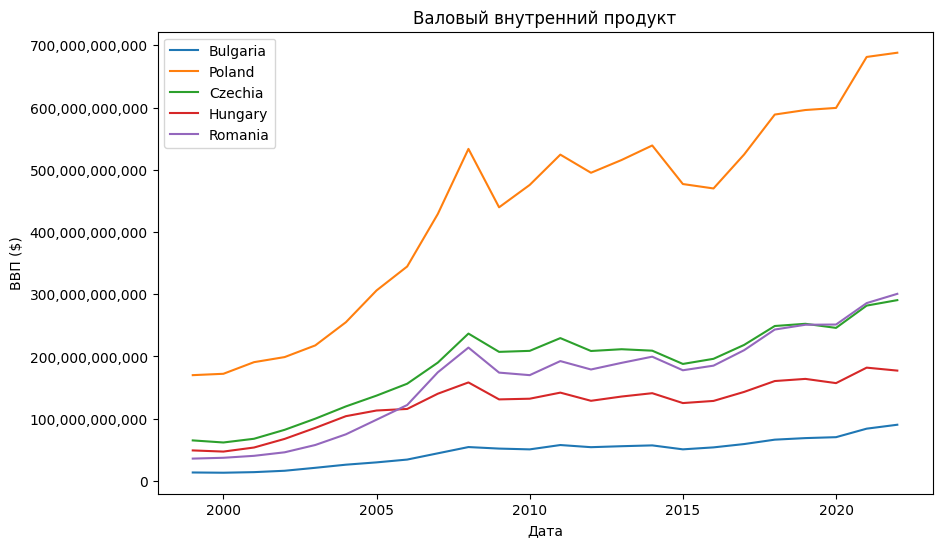

In [103]:
#Выводим визуализацию
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x['Year'], x['Bulgaria'], label='Bulgaria')
ax.plot(x['Year'], x['Poland'], label='Poland')
ax.plot(x['Year'], x['Czechia'], label='Czechia')
ax.plot(x['Year'], x['Hungary'], label='Hungary')
ax.plot(x['Year'], x['Romania'], label='Romania')
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)) #Необходимо для точной визуализации числовых данных
ax.yaxis.set_major_formatter(formatter)
ax.set_xlabel('Дата')
ax.set_ylabel('ВВП ($)')
ax.set_title('Валовый внутренний продукт')
ax.legend()
plt.show()

In [104]:
#Остальные данные были получены, отформатированы и выведены аналогично

# ***ИНФЛЯЦИЯ***

In [105]:
Inflation = 'https://data.worldbank.org/indicator/FP.CPI.TOTL.ZG'
page = requests.get(Inflation)
soup = BeautifulSoup(page.text, "html.parser")
Inflation_file = soup.find_all('div', class_='btn-item download')
Inflation = Inflation_file[0].find_all('a')
Inflation = Inflation[-1].get('href')
url = f'{Inflation}'
response = requests.get(url)
df1 = pd.read_excel(BytesIO(response.content))
df1.columns = df1.iloc[2]
df1 = df1.drop([0, 1, 2])
skip_cols = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
for col in df1.columns:
    if col not in skip_cols:
        df1.rename(columns={col: int(float(col))}, inplace=True)
pd.options.display.float_format ='{:,.0f}'.format
df1.columns.name = None
df1.index = range(0, len(df1), 1)
Inflation_df = df1
Inflation_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,-1,-1,4,4,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5,5,7,6,5,5,7,7,11,NaN
2,Afghanistan,AFG,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5,-1,4,5,1,2,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2,1,2,2,2,2,4,8,NaN
4,Angola,AGO,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,7,9,31,30,20,17,22,26,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,0,-1,0,1,1,3,0,3,12,NaN
262,"Yemen, Rep.",YEM,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,1,2,1,1,3,4,...,6,5,7,5,5,4,3,5,7,NaN
264,Zambia,ZMB,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,8,10,18,7,7,9,16,22,11,NaN


In [106]:
sorted_df = Inflation_df.loc[countries, columns]
sorted_df.index = range(0, len(sorted_df), 1)
y = sorted_df.T
y.columns = y.iloc[0]
y['Year'] = y.index
y.index = range(0,len(y), 1)
y = y[['Year', 'Bulgaria', 'Poland', 'Czechia', 'Hungary', 'Romania']]
y = y.drop([0])
y.index = range(0,len(y), 1)
y.columns.name = None
y['Bul_Diff'] = y['Bulgaria'].diff()
y['Pol_Diff'] = y['Poland'].diff()
y['Cze_Diff'] = y['Czechia'].diff()
y['Hun_Diff'] = y['Hungary'].diff()
y['Rom_Diff'] = y['Romania'].diff()
y

,Year,Bulgaria,Poland,Czechia,Hungary,Romania,Bul_Diff,Pol_Diff,Cze_Diff,Hun_Diff,Rom_Diff
0,1999,3,7,2,10,46,NaN,NaN,NaN,NaN,NaN
1,2000,10,10,4,10,46,8,3,2,-0,-0
2,2001,7,5,5,9,34,-3,-4,1,-1,-11
3,2002,6,2,2,5,23,-2,-4,-3,-4,-12
4,2003,2,1,0,5,15,-3,-1,-2,-1,-7
5,2004,6,3,3,7,12,4,3,3,2,-3
6,2005,5,2,2,4,9,-1,-1,-1,-3,-3
7,2006,7,1,3,4,7,2,-1,1,0,-2
8,2007,8,2,3,8,5,1,1,0,4,-2
9,2008,12,4,6,6,8,4,2,4,-2,3


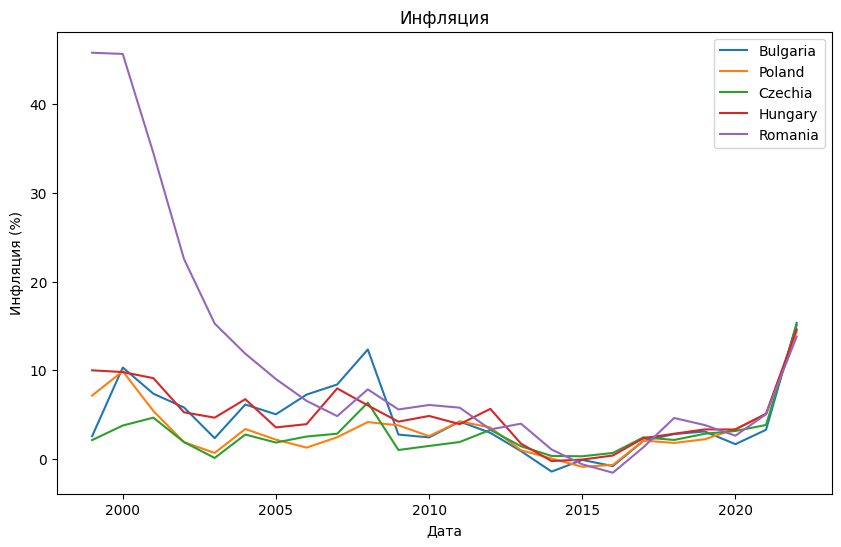

In [107]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y['Year'], y['Bulgaria'], label='Bulgaria')
ax.plot(y['Year'], y['Poland'], label='Poland')
ax.plot(y['Year'], y['Czechia'], label='Czechia')
ax.plot(y['Year'], y['Hungary'], label='Hungary')
ax.plot(y['Year'], y['Romania'], label='Romania')
ax.set_xlabel('Дата')
ax.set_ylabel('Инфляция (%)')
ax.set_title('Инфляция')
ax.legend()
plt.show()

# ***БЕЗРАБОТИЦА***

In [108]:
Unemployment = 'https://data.worldbank.org/indicator/SL.UEM.TOTL.NE.ZS'
page = requests.get(Unemployment)
soup = BeautifulSoup(page.text, "html.parser")
Unemployment_file = soup.find_all('div', class_='btn-item download')
Unemployment = Unemployment_file[0].find_all('a')
Unemployment = Unemployment[-1].get('href')
url = f'{Unemployment}'
response = requests.get(url)
df1 = pd.read_excel(BytesIO(response.content))
df1.columns = df1.iloc[2]
df1 = df1.drop([0, 1, 2])
skip_cols = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
for col in df1.columns:
    if col not in skip_cols:
        df1.rename(columns={col: int(float(col))}, inplace=True)
pd.options.display.float_format ='{:,.0f}'.format
df1.columns.name = None
df1.index = range(0, len(df1), 1)
Unemployment_df = df1
Unemployment_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,Aruba,ABW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,8,NaN,NaN,11,NaN,NaN,12,6,NaN,NaN
3,Africa Western and Central,AFW,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,4,NaN,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,10,NaN,NaN,NaN,NaN,16,NaN,16,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,35,33,27,30,28,25,25,20,12,NaN
262,"Yemen, Rep.",YEM,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,South Africa,ZAF,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,23,23,24,24,24,26,24,29,29,28
264,Zambia,ZMB,"Unemployment, total (% of total labor force) (...",SL.UEM.TOTL.NE.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,12,NaN,9,5,6,6,5,6,NaN


In [109]:
sorted_df = Unemployment_df.loc[countries, columns]
sorted_df.index = range(0, len(sorted_df), 1)
z = sorted_df.T
z.columns = z.iloc[0]
z['Year'] = z.index
z.index = range(0,len(z), 1)
z = z[['Year', 'Bulgaria', 'Poland', 'Czechia', 'Hungary', 'Romania']]
z = z.drop([0])
z.index = range(0,len(z), 1)
z.columns.name = None
z['Bul_Diff'] = z['Bulgaria'].diff()
z['Pol_Diff'] = z['Poland'].diff()
z['Cze_Diff'] = z['Czechia'].diff()
z['Hun_Diff'] = z['Hungary'].diff()
z['Rom_Diff'] = z['Romania'].diff()
z

,Year,Bulgaria,Poland,Czechia,Hungary,Romania,Bul_Diff,Pol_Diff,Cze_Diff,Hun_Diff,Rom_Diff
0,1999,14,12,9,7,6,NaN,NaN,NaN,NaN,NaN
1,2000,16,16,9,7,7,2,4,0,-0,1
2,2001,20,18,8,6,7,4,2,-1,-1,-0
3,2002,18,20,7,6,8,-2,2,-1,-0,2
4,2003,14,19,8,6,7,-4,-1,0,0,-1
5,2004,12,19,8,6,8,-2,-0,1,0,1
6,2005,10,18,8,7,7,-2,-1,-0,1,-1
7,2006,9,14,7,7,7,-1,-4,-1,0,0
8,2007,7,10,5,7,6,-2,-4,-2,-0,-1
9,2008,6,7,4,8,6,-1,-2,-1,0,-1


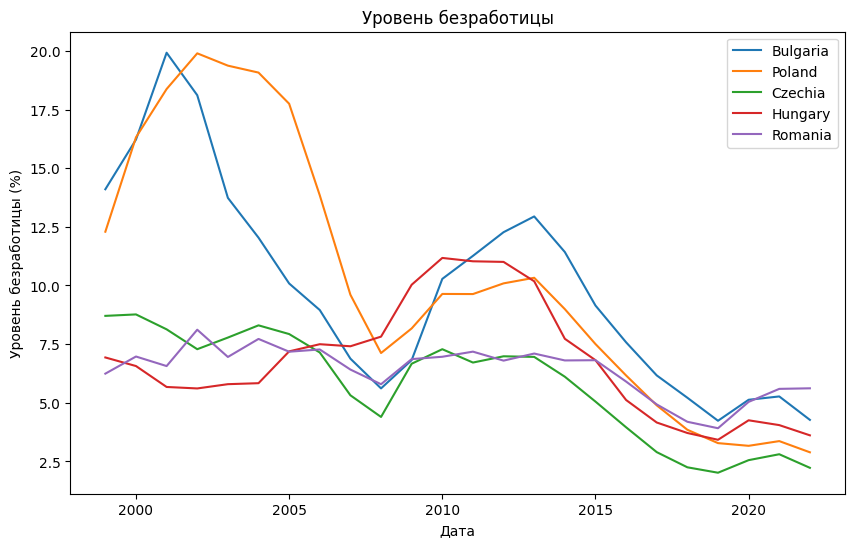

In [110]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(z['Year'], z['Bulgaria'], label='Bulgaria')
ax.plot(z['Year'], z['Poland'], label='Poland')
ax.plot(z['Year'], z['Czechia'], label='Czechia')
ax.plot(z['Year'], z['Hungary'], label='Hungary')
ax.plot(z['Year'], z['Romania'], label='Romania')
ax.set_xlabel('Дата')
ax.set_ylabel('Уровень безработицы (%)')
ax.set_title('Уровень безработицы')
ax.legend()
plt.show()

# ***Новый признак***

Новый признак, который мы хотим добавить для 5 выбранных стран - **Индекс экономической стабильности (IES)**, который расчитывается по следующей формуле:
$$
\text{IES} = \frac{\text{ВВП}}{\text{Инфляция} + \text{Уровень безработицы}}
$$


In [111]:
IES = pd.DataFrame()
IES['YEAR'] = x['Year']
IES['IES_BUL'] = x['Bulgaria']/(y['Bulgaria']+z['Bulgaria'])
IES['IES_POL'] = x['Poland']/(y['Poland']+z['Poland'])
IES['IES_CZE'] = x['Czechia']/(y['Czechia']+z['Czechia'])
IES['IES_HUN'] = x['Hungary']/(y['Hungary']+z['Hungary'])
IES['IES_ROM'] = x['Romania']/(y['Romania']+z['Romania'])
IES

,YEAR,IES_BUL,IES_POL,IES_CZE,IES_HUN,IES_ROM
0,1999,"817,326,844","8,744,601,139","6,013,696,981","2,899,162,409","690,838,498"
1,2000,"499,203,264","6,569,745,156","4,930,716,320","2,885,044,942","707,767,057"
2,2001,"519,884,085","8,027,534,614","5,301,364,467","3,634,749,994","984,310,154"
3,2002,"685,741,862","9,131,553,772","8,949,931,551","6,217,799,340","1,502,860,291"
4,2003,"1,314,850,709","10,862,808,804","12,676,516,407","8,160,455,890","2,601,139,009"
5,2004,"1,438,492,922","11,359,988,613","10,834,985,184","8,279,099,006","3,826,482,191"
6,2005,"1,975,200,218","15,361,216,090","14,016,976,614","10,530,763,971","6,081,593,071"
7,2006,"2,120,606,682","22,784,188,858","16,151,340,098","10,128,879,220","8,824,067,062"
8,2007,"2,907,804,871","35,571,668,431","23,280,806,145","9,123,920,714","15,518,548,706"
9,2008,"3,033,661,943","47,292,484,868","22,026,031,518","11,423,606,288","15,713,784,372"


# ***Проверка гипотезы***

***Гипотеза:*** $$
\begin{aligned}
&H_о: μ_b=μ_e \\
&H_а: μ_b≠μ_e
\end{aligned}
$$

Проверяем гипотезу для пар: ВВП и уровень безработицы, инфляция и уровень безработицы.
За основу берем процентное изменение этих показателей
Считаем, что наши выборки связаны, так как они являются экономическими показателями для одной страны за один период времени

Проверять гипотезы мы будем на уровне значимости 5%

***ВВП и уровень безработицы***

In [112]:
#Берем срез по 23 значениям из-за пустой 1 строки

In [113]:
result_BUL = stats.ttest_rel(x['Bul_Percent'][-23:], z['Bul_Diff'][-23:])
result_POL = stats.ttest_rel(x['Pol_Percent'][-23:], z['Pol_Diff'][-23:])
result_CZE = stats.ttest_rel(x['Cze_Percent'][-23:], z['Cze_Diff'][-23:])
result_HUN = stats.ttest_rel(x['Hun_Percent'][-23:], z['Hun_Diff'][-23:])
result_ROM = stats.ttest_rel(x['Rom_Percent'][-23:], z['Rom_Diff'][-23:])
print(f'p-value для ВВП и уровня безработицы Болгарии: {round(result_BUL.pvalue, 4)}, следовательно гипотеза отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Польши: {round(result_POL.pvalue, 4)}, следовательно гипотеза отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Чехии: {round(result_CZE.pvalue, 4)}, следовательно гипотеза отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Венгрии: {round(result_HUN.pvalue, 4)}, следовательно гипотеза отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Румынии: {round(result_ROM.pvalue, 4)}, следовательно гипотеза отвергается на уровне значимости 5%')

p-value для ВВП и уровня безработицы Болгарии: 0.0011, следовательно гипотеза отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Польши: 0.0058, следовательно гипотеза отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Чехии: 0.0045, следовательно гипотеза отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Венгрии: 0.015, следовательно гипотеза отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Румынии: 0.0023, следовательно гипотеза отвергается на уровне значимости 5%


***Инфляция и уровень безработицы***

In [114]:
result_BUL1 = stats.ttest_rel(y['Bul_Diff'][-23:], z['Bul_Diff'][-23:])
result_POL1 = stats.ttest_rel(y['Pol_Diff'][-23:], z['Pol_Diff'][-23:])
result_CZE1 = stats.ttest_rel(y['Cze_Diff'][-23:], z['Cze_Diff'][-23:])
result_HUN1 = stats.ttest_rel(y['Hun_Diff'][-23:], z['Hun_Diff'][-23:])
result_ROM1 = stats.ttest_rel(y['Rom_Diff'][-23:], z['Rom_Diff'][-23:])
print(f'p-value для ВВП и уровня безработицы Болгарии: {round(result_BUL1.pvalue, 2)}, следовательно гипотеза не отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Польши: {round(result_POL1.pvalue, 2)}, следовательно гипотеза не отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Чехии: {round(result_CZE1.pvalue, 2)}, следовательно гипотеза не отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Венгрии: {round(result_HUN1.pvalue, 2)}, следовательно гипотеза не отвергается на уровне значимости 5%')
print(f'p-value для ВВП и уровня безработицы Румынии: {round(result_ROM1.pvalue, 2)}, следовательно гипотеза не отвергается на уровне значимости 5%')

p-value для ВВП и уровня безработицы Болгарии: 0.33, следовательно гипотеза не отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Польши: 0.33, следовательно гипотеза не отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Чехии: 0.24, следовательно гипотеза не отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Венгрии: 0.6, следовательно гипотеза не отвергается на уровне значимости 5%
p-value для ВВП и уровня безработицы Румынии: 0.17, следовательно гипотеза не отвергается на уровне значимости 5%


# ***Обучение модели***


In [115]:
df = y
df['Bulgaria_U'] = z['Bulgaria']
df['Poland_U'] = z['Poland']
df['Czechia_U'] = z['Czechia']
df['Hungary_U'] = z['Hungary']
df['Romania_U'] = z['Romania']
df = df.apply(pd.to_numeric, errors='coerce')
x = x.apply(pd.to_numeric, errors='coerce')

Модель имеет вид:
$$
Изменение ВВП = w_0 + w_1 \cdot Инфляция + w_2 \cdot УровеньБезработицы
$$


***Болгария***

In [116]:
#Делим выборку на обучающую и тестовую
X = df[['Bulgaria', 'Bulgaria_U']][-23:]
Y = x['Bul_Percent'][-23:]
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, test_size = .2)
#Обучаем модель (на обучающей выборке)
y_train = np.array(y_train).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [117]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})
lin_model.coef_ #коэфициенты перед независимыми переменными

array([[1.2, -0.2]])

In [118]:
lin_model.intercept_ #свободный коэффициент

array([4.9])

In [119]:
y_test_pred = lin_model.predict(X_test)
round(mean_squared_error(y_test, y_test_pred)) #MSE

141

In [120]:
r2_score(y_test, y_test_pred) #коэффициент детерминации

-0.608941563899837

***Польша***

In [121]:
#Делим выборку на обучающую и тестовую
X = df[['Poland', 'Poland_U']][-23:]
Y = x['Pol_Percent'][-23:]
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, test_size = .2)
#Обучаем модель (на обучающей выборке)
y_train = np.array(y_train).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [122]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})
lin_model.coef_ #коэфициенты перед независимыми переменными

array([[-0.3, 0.1]])

In [123]:
lin_model.intercept_ #свободный коэффициент

array([8.0])

In [124]:
y_test_pred = lin_model.predict(X_test)
round(mean_squared_error(y_test, y_test_pred)) #MSE

245

In [125]:
r2_score(y_test, y_test_pred) #коэффициент детерминации

-0.21734252573949875

***Чехия***

In [126]:
#Делим выборку на обучающую и тестовую
X = df[['Czechia', 'Czechia_U']][-23:]
Y = x['Cze_Percent'][-23:]
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, test_size = .2)
#Обучаем модель (на обучающей выборке)
y_train = np.array(y_train).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [127]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})
lin_model.coef_ #коэфициенты перед независимыми переменными

array([[0.1, 0.6]])

In [128]:
lin_model.intercept_ #свободный коэффициент

array([3.1])

In [129]:
y_test_pred = lin_model.predict(X_test)
round(mean_squared_error(y_test, y_test_pred)) #MSE

176

In [130]:
r2_score(y_test, y_test_pred) #коэффициент детерминации

-0.05154927808946508

***Венгрия***

In [131]:
#Делим выборку на обучающую и тестовую
X = df[['Hungary', 'Hungary_U']][-23:]
Y = x['Hun_Percent'][-23:]
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, test_size = .2)
#Обучаем модель (на обучающей выборке)
y_train = np.array(y_train).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [132]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})
lin_model.coef_ #коэфициенты перед независимыми переменными

array([[-0.6, -1.3]])

In [133]:
lin_model.intercept_ #свободный коэффициент

array([18.5])

In [134]:
y_test_pred = lin_model.predict(X_test)
round(mean_squared_error(y_test, y_test_pred)) #MSE

293

In [135]:
r2_score(y_test, y_test_pred) #коэффициент детерминации

-0.12156720971502133

***Румыния***

In [136]:
#Делим выборку на обучающую и тестовую
X = df[['Romania', 'Romania_U']][-23:]
Y = x['Rom_Percent'][-23:]
(X_train, X_test, y_train, y_test) = train_test_split(X, Y, test_size = .2)
#Обучаем модель (на обучающей выборке)
y_train = np.array(y_train).reshape(-1, 1)
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

LinearRegression()

In [137]:
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.1f}'.format})
lin_model.coef_ #коэфициенты перед независимыми переменными

array([[-0.1, 4.0]])

In [138]:
lin_model.intercept_ #свободный коэффициент

array([-11.9])

In [139]:
y_test_pred = lin_model.predict(X_test)
round(mean_squared_error(y_test, y_test_pred)) #MSE

344

In [140]:
r2_score(y_test, y_test_pred) #коэффициент детерминации

-1.2165674231544812

***Вывод:*** Модели достаточно плохо предсказывают показатели, что, скорее всего, связано с тем, что ВВП (или его изменение) - показатель, который зависит от огромного числа показателей, а мы пытаемся прогнозировать его лишь на основе двух - инфляции и уровня безработицы